In [ ]:
"""
 - get probability matrix
 - calculate randomwalk, wasserstein, symmetric KL, jaccard sp
 - plot results along with jaccard-shortest
"""

In [137]:
from scipy.io import loadmat
from scipy.sparse import find
from scipy.sparse.csgraph import dijkstra
from scipy.linalg import sqrtm
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree, to_tree
from scipy.spatial.distance import pdist, squareform
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import adjusted_rand_score
import numpy as np
import numpy.linalg as lalg
import matplotlib.pyplot as plt
import networkx as nx
from networkx.generators.community import LFR_benchmark_graph
from pickle import dump, load, HIGHEST_PROTOCOL

%matplotlib inline

In [95]:
def wrangle_karate():
    mat = loadmat('karate.mat')
    S = mat['Problem'][0][0][2]
    G = nx.Graph(S)

    mr_hi = set([1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17, 18, 20, 22])
    split = {}
    cols = {}
    for i in G.nodes:
        split[i] = 0 if i+1 in mr_hi else 1
        cols[i] = 'red' if i+1 in mr_hi else 'black'
    nx.set_node_attributes(G, split, 'cluster')
    nx.set_node_attributes(G, cols, 'color')
    return G

In [96]:
def wrangle_football():
    # data fixed by Tim Evans
    mat = loadmat('football_fixed.mat')
    I,J = mat['links']
    G = nx.Graph()
    G.add_edges_from(zip(I,J))

    confs = {}
    cols = {}
    cmap = plt.get_cmap('tab20')
    for node in mat['nodes']:
        idx = int(node[0])
        conf = int(node[2])
        assert idx not in confs.keys()
        if conf>10:
            confs[idx] = conf
            cols[idx] = 'black'
        else:
            confs[idx] = conf
            cols[idx] = cmap(conf/11)
    nx.set_node_attributes(G, confs, 'cluster')
    nx.set_node_attributes(G, cols, 'color')
    return G

In [97]:
def wrangle_caltech():
    mat = loadmat('Caltech36.mat')
    G = nx.Graph(mat['A'])

    houses = {}
    cols = {}
    cmap = plt.get_cmap('tab10')
    for i,x in enumerate(mat['local_info']):
        house = x[4]
        if house==0:
            houses[i] = house
            cols[i] = 'black'
        else:
            houses[i] = house
            cols[i] = cmap((house-165)/10)
    nx.set_node_attributes(G, houses, 'cluster')
    nx.set_node_attributes(G, cols, 'color')
    return G

In [116]:
def generate_lfr():
    G = LFR_benchmark_graph(n=250, tau1=3, tau2=1.5, mu=.1, average_degree=5, min_community=20, seed=10)
    communities = nx.get_node_attributes(G, 'community')
    seen = set()
    clust_idx = 0
    clusts = {}
    cols = {}
    cmap = plt.get_cmap('tab10')
    for idx,community in communities.items():
        if idx not in seen:
            for member in community:
                clusts[member] = clust_idx
                cols[member] = cmap(clust_idx/10)
                seen.add(member)
            clust_idx += 1
    nx.set_node_attributes(G, clusts, 'cluster')
    nx.set_node_attributes(G, cols, 'color')
    return G

In [112]:
def largest_connected_component(G):
    G = G.subgraph(max(nx.connected_components(G), key=len))
    G = nx.relabel.convert_node_labels_to_integers(G, label_attribute='orig')
    return G

In [124]:
def is_metric(dist, eps=0):
    square = squareform(dist)
    n,m = square.shape
    assert n==m
    for i in range(n):
        for j in range(n):
            for k in range(n):
                if square[i,j] > square[i,k]+square[k,j]+eps:
                    print(f'{i} {j} {k}')
                    print(square[i,j])
                    print(square[i,k]+square[k,j])
                    return False
    return True

def draw_dendrogram(G, hierarchy):
    plt.figure(figsize=(20,5))
    plt.rcParams["font.weight"] = "bold"
    dend = dendrogram(hierarchy, leaf_rotation=90, leaf_font_size=8)

    ticks, labels = plt.xticks()
    for label in labels:
        idx = int(label.get_text())
        label.set_color(G.nodes[idx]['color'])
    plt.xticks(ticks, labels)

def eval_ARI(G, hierarchy):
    """calculates the adjusted rand index to evaluate cluster quality"""
    attrs = nx.get_node_attributes(G, 'cluster')
    n = len(G)
    gtruth = []
    ignore = set() # unuseful labels are set to -1 earlier
    for idx,label in attrs.items():
        if label >= 0:
            gtruth.append(label)
        else:
            ignore.add(idx)
    labelset = set(gtruth)
    predicted = []
    
    # try cutting at every dendrogram branch
    cut = cut_tree(hierarchy).transpose()
    best = -float('inf')
    argbest = -1
    for n_clust, clusters in enumerate(cut):
        score = adjusted_rand_score(gtruth, clusters)
        if score > best:
            best = score
            argbest = n_clust
    return best, n-argbest

In [121]:
def markov_matrix(G):
    '''gets the markov matrix and diagonal degrees matrix (used again for walktrap) from a graph G'''
    n = len(G)
    A = nx.to_numpy_array(G)

    for i in range(n):
        for j in range(i+1,n):
            assert A[i,j]==A[j,i]

    D = np.identity(n) * np.sum(A, axis=1)
    P = lalg.inv(D) @ A
    return P,D

def embed_snapshot_markov(markov, degrees, steps=4):
    '''embedding of pons & lapaty'''
    return lalg.inv(sqrtm(degrees)) @ lalg.matrix_power(markov,steps)

def embed_damped_markov(markov, damping, steps=100):
    '''weights each markov chain state according to a damping factor'''
    state = np.array(markov)
    final = np.array(markov)
    totaldamp = 1
    currdamp = damping
    for i in range(1,steps):
        state = state @ markov
        final += currdamp * state
        totaldamp += currdamp
        currdamp *= damping
    final /= totaldamp
    return final

In [127]:
# different linkage methods

def cluster_walktrap(embedding, opt_ord=False):
    dist = pdist(embedding, metric='euclidean')
    # print(is_metric(dist))
    return linkage(dist, method='ward', optimal_ordering=opt_ord)
    
def KL_symmetric(embedding, opt_ord=False):
    if min(np.nditer(embedding)) <= 0:
        return (-float('inf'), 0)
    dist = pdist(embedding, metric=lambda x,y: entropy(x,y)+entropy(y,x))
    # print(is_metric(dist))
    return linkage(dist, method='ward', optimal_ordering=opt_ord)

def wasserstein(embedding, opt_ord=False):
    dist = pdist(embedding, wasserstein_distance)
    # print(is_metric(squareform(dist), 1e-10))
    return linkage(dist, method='ward', optimal_ordering=opt_ord)

def jaccard_sp(G, opt_ord=False):
    A = nx.to_numpy_array(G)
    jacc = pdist(A, metric='jaccard')
    bacon = dijkstra(A, directed=False, unweighted=True)
    dist = jacc * squareform(bacon)

    # print(is_metric(dist))
    return linkage(dist, method='ward', optimal_ordering=opt_ord)

def commute(G, opt_ord=False):
    # first get unnormalised laplacian
    n = len(G)
    A = nx.to_numpy_array(G)
    D = np.identity(n) * np.sum(A, axis=1)
    L = D-A
    
    # get moore-penrose pseudo-inverse
    Lplus = lalg.pinv(L)
    vol = 2*len(G.edges)
    
    # use to calculate ECT
    def commute(i,j):
        return vol * (Lplus[i,i] + Lplus[j,j] - 2*Lplus[i,j])
    
    dist = []
    for i in range(n):
        for j in range(i+1,n):
            dist.append(commute(i,j))
    # print(is_metric(dist, 1e-10))
    return linkage(dist, method='ward', optimal_ordering=opt_ord)

In [128]:
def do_experiment(filename, G):
    G = largest_connected_component(G)
    # jaccard * shortestpaths
    results = {}
    results['jaccsp'] = eval_ARI(G, jaccard_sp(G))

    # euclidean commute time
    results['commute'] = eval_ARI(G, commute(G))

    # prepare markov chain for embedding
    markov, degrees = markov_matrix(G)
    identity = np.identity(len(G))

    # walktrap, KL, wasserstein (all with both types of embedding)
    all_steps = [1,2,3,4,5,6,7,8,9,10,100]
    for steps in all_steps:
        embedding = embed_snapshot_markov(markov, degrees, steps)
        results[f'snapshotD_walktrap_{steps:03d}'] = eval_ARI(G, cluster_walktrap(embedding))
        results[f'snapshotD_KL_{steps:03d}'] = eval_ARI(G, KL_symmetric(embedding))
        results[f'snapshotD_wasserstein_{steps:03d}'] = eval_ARI(G, wasserstein(embedding))

        embedding = embed_snapshot_markov(markov, identity, steps)
        results[f'snapshotI_walktrap_{steps:03d}'] = eval_ARI(G, cluster_walktrap(embedding))
        results[f'snapshotI_KL_{steps:03d}'] = eval_ARI(G, KL_symmetric(embedding))
        results[f'snapshotI_wasserstein_{steps:03d}'] = eval_ARI(G, wasserstein(embedding))

    # damped markov embedding
    all_damps = [.1,.2,.3,.4,.5,.6,.7,.8,.85,.9,1]
    for damp in all_damps:
        embedding = embed_damped_markov(markov, damp)
        dampstr = str(damp).replace('.','p')
        results[f'damped_walktrap_{dampstr}'] = eval_ARI(G, cluster_walktrap(embedding))
        results[f'damped_KL_{dampstr}'] = eval_ARI(G, KL_symmetric(embedding))
        results[f'damped_wasserstein_{dampstr}'] = eval_ARI(G, wasserstein(embedding))

    with open(f'{filename}.pkl', 'wb') as f: 
        dump(results, f, HIGHEST_PROTOCOL)

In [119]:
do_experiment('karate', wrangle_karate())
do_experiment('football', wrangle_football())
do_experiment('caltech', wrangle_caltech())
do_experiment('lfr', generate_lfr())

(0.8288552927444437, 5)

In [133]:
with open(f'karate.pkl', 'rb') as f:
    results = load(f)
    for label, result in sorted(results.items()):
        print(f"{label:<25} {result[0]:.3f} {result[1]}")

commute                   0.767 4
damped_KL_0p1             1.000 2
damped_KL_0p2             1.000 2
damped_KL_0p3             0.882 2
damped_KL_0p4             0.882 2
damped_KL_0p5             0.882 2
damped_KL_0p6             1.000 2
damped_KL_0p7             1.000 2
damped_KL_0p8             0.572 2
damped_KL_0p85            0.572 2
damped_KL_0p9             0.572 2
damped_KL_1               0.669 2
damped_walktrap_0p1       0.457 5
damped_walktrap_0p2       1.000 2
damped_walktrap_0p3       1.000 2
damped_walktrap_0p4       1.000 2
damped_walktrap_0p5       1.000 2
damped_walktrap_0p6       1.000 2
damped_walktrap_0p7       1.000 2
damped_walktrap_0p8       1.000 2
damped_walktrap_0p85      1.000 2
damped_walktrap_0p9       1.000 2
damped_walktrap_1         1.000 2
damped_wasserstein_0p1    0.053 26
damped_wasserstein_0p2    0.053 26
damped_wasserstein_0p3    0.053 26
damped_wasserstein_0p4    0.053 26
damped_wasserstein_0p5    0.053 26
damped_wasserstein_0p6    0.053 26
damped_w

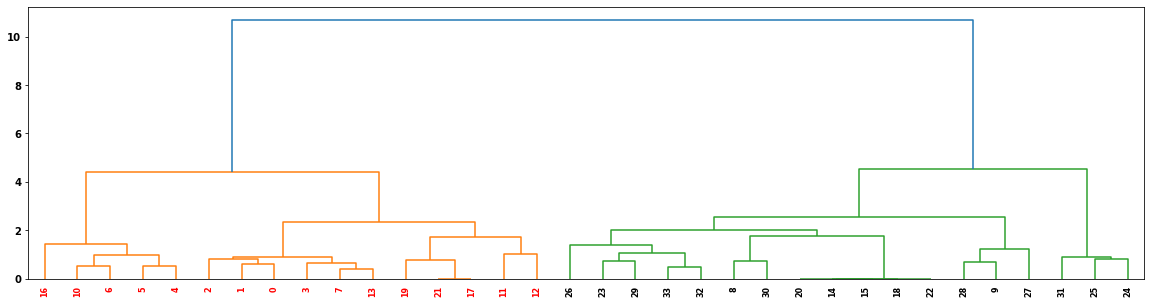

In [146]:
G = wrangle_karate()
Z = jaccard_sp(G, opt_ord=True)
draw_dendrogram(G, Z)
root = to_tree(Z)
with open(f'dendrogram_karate.pkl', 'wb') as f: 
    dump(root, f, HIGHEST_PROTOCOL)